
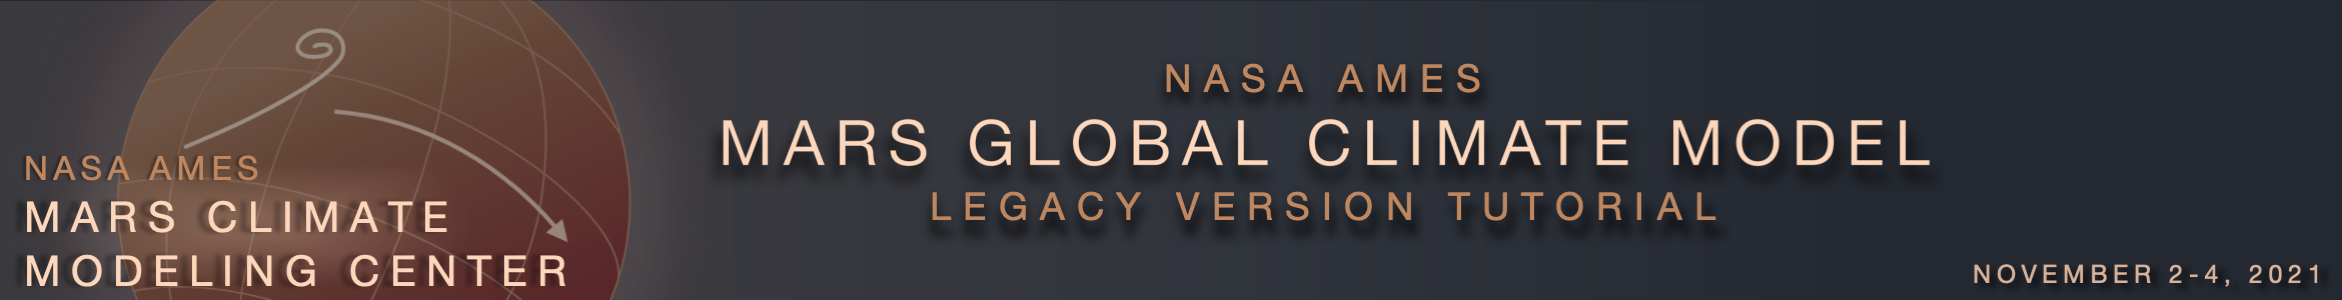


# GCM Overview: Lecture
## Introduction

Welcome to the overview portion of the Mars Climate Modeling Center (MCMC) Legacy Mars Global Climate Model (GCM) tutorial.  By the end of this section of the tutorial, you will have a basic understanding of the main components and structure of the GCM.

The GCM presented here is extensively documented in [Haberle et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0019103518305761) for your reference.

---


# Outline: GCM Overview

1.  [What is a GCM?](#1.-What-is-a-GCM?)
2.  [Dynamical Core](#2.-Dynamical-Core)
3.  [Physical Processes](#3.-Physical-Processes)
4.  [Horizontal Grid Structure](#4.-Horizontal-Grid-Structure)
5.  [Vertical Grid Structure](#5.-Vertical-Grid-Structure)
6.  [Time Stepping](#6.-Time-Stepping)
7.  [Code Architecture](#7.-Code-Architecture)

---



# 1. What is a GCM?

A GCM is a discretized numerical model of a planet's atmosphere that advances through time by solving a set of equations to conserve momentum, mass, and energy.  GCMs can generally be divided into two parts based on a slightly rearranged version of Newton's second law:

$$\frac{f}{m}=a$$

- PART 1: The model **geophysical fluid dynamics**, which represent accelerations $\left(a\right)$.
    - Adiabatic processes, computed in the dynamical core


- PART 2: The model **physics**, which provide the forcing functions for the circulation $\left(\frac{f}{m}\right)$.
    - Diabatic processes, computed in the physics routines
    - For Mars, it is critical to realistically represent the radiative effects of atmospheric dust and clouds

|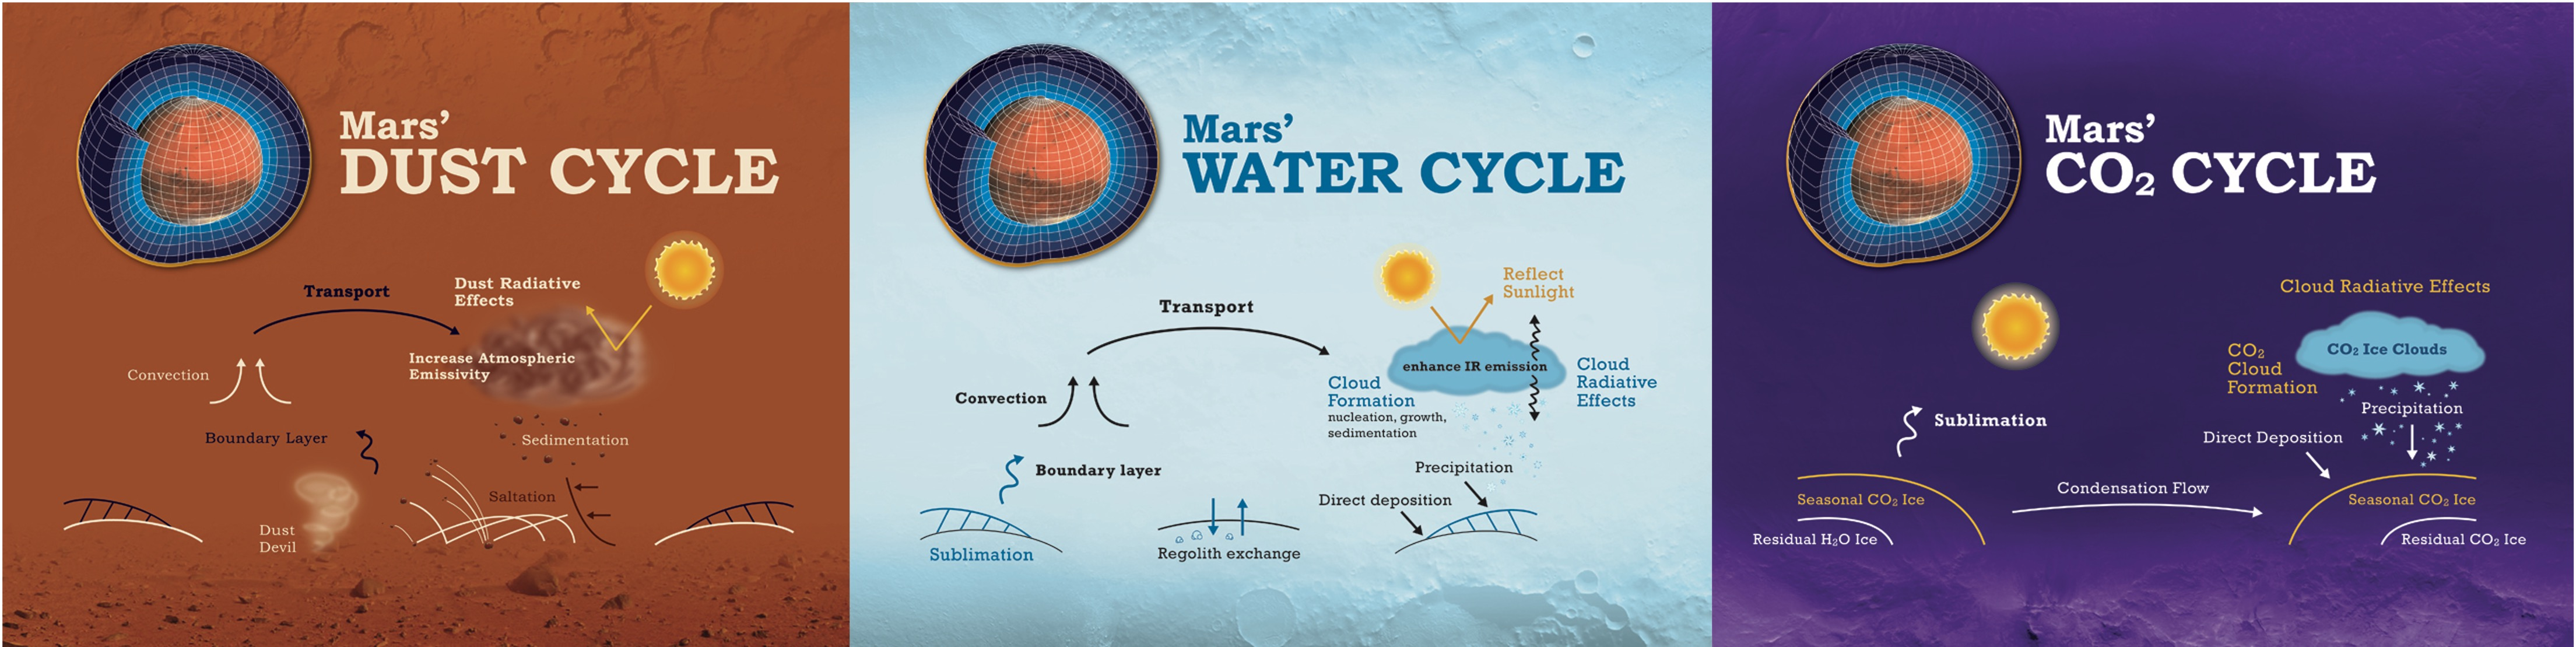|
| --- |
| *Model Physics: The Dust, Water, and CO<sub>2</sub> cycles on Mars.* |

---


# 2. Dynamical Core (DYCORE)

### Overview:
- The Legacy GCM utilizes the NASA GSFC ARIES/GEOS dynamical core ([Suarez and Takacs, 1995](https://gmao.gsfc.nasa.gov/gmaoftp/takacs/gcm/aries.geos.dycore.ver2.ps.Z))
- Tracer transport is based on the Van Leer I scheme ([Hourdin and Armengaud, 1998](https://journals.ametsoc.org/view/journals/mwre/127/5/1520-0493_1999_127_0822_tuofvm_2.0.co_2.xml))

|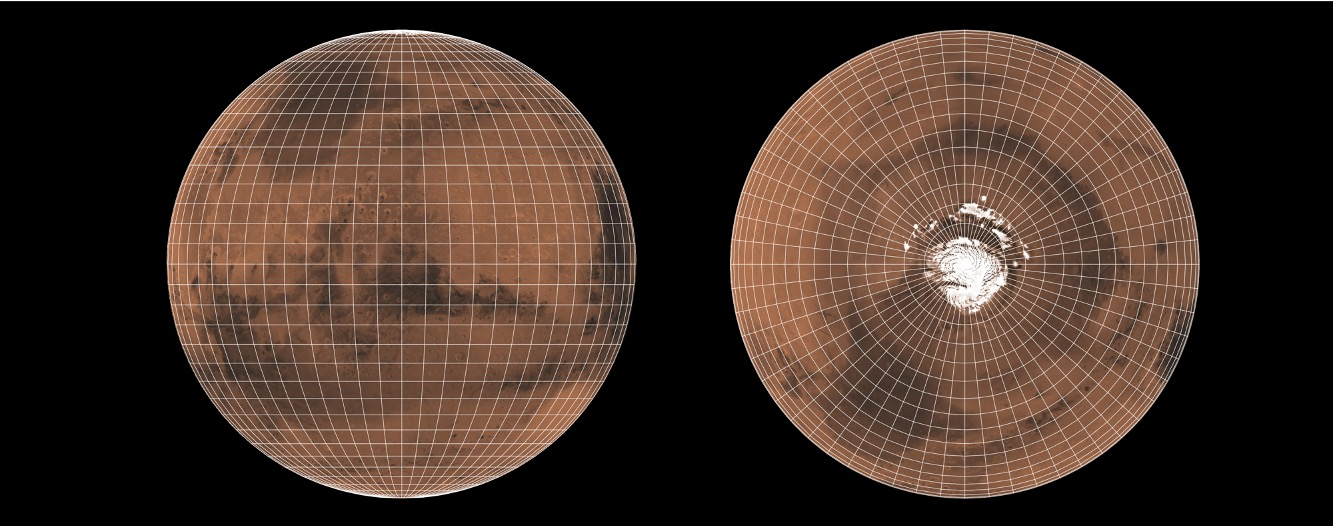|
| --- |
| *GCM Latitude-Longitude Horizontal Grid* |


### Purpose:
- Computes pressure, wind, potential temperature, and tracer tendencies every dynamical timestep (~2 minutes).

### Methodology:

- Solves the **primitive equations of meteorology** in spherical coordinates using finite differences ([Holton and Hakim, 2013](https://www.sciencedirect.com/book/9780123848666/an-introduction-to-dynamic-meteorology)):
    - Momentum equations in $U$ and $V$
    - Continuity equation
    - Hydrostatic equation
    - Thermodynamic energy equation


- **Tracer transport** is based on the flux form of the **continuity and advection equations**
    - Estimate distribution of tracer mixing ratio in each grid-box with a slope
    - Allows for transport across more than one grid in one timestep in the zonal direction only


- Grid Structure
    - Horizontal:  **Arakawa C-Grid** (Staggered $U$ and $V$ winds)
        - Nominal Resolution: 5<sup>o</sup> latitude by 6<sup>o</sup> longitude
    - Vertical: **Sigma (terrain-following) coordinate**
        - Nominally 24 layers
        - Nominal model top at **~80 km**
  
|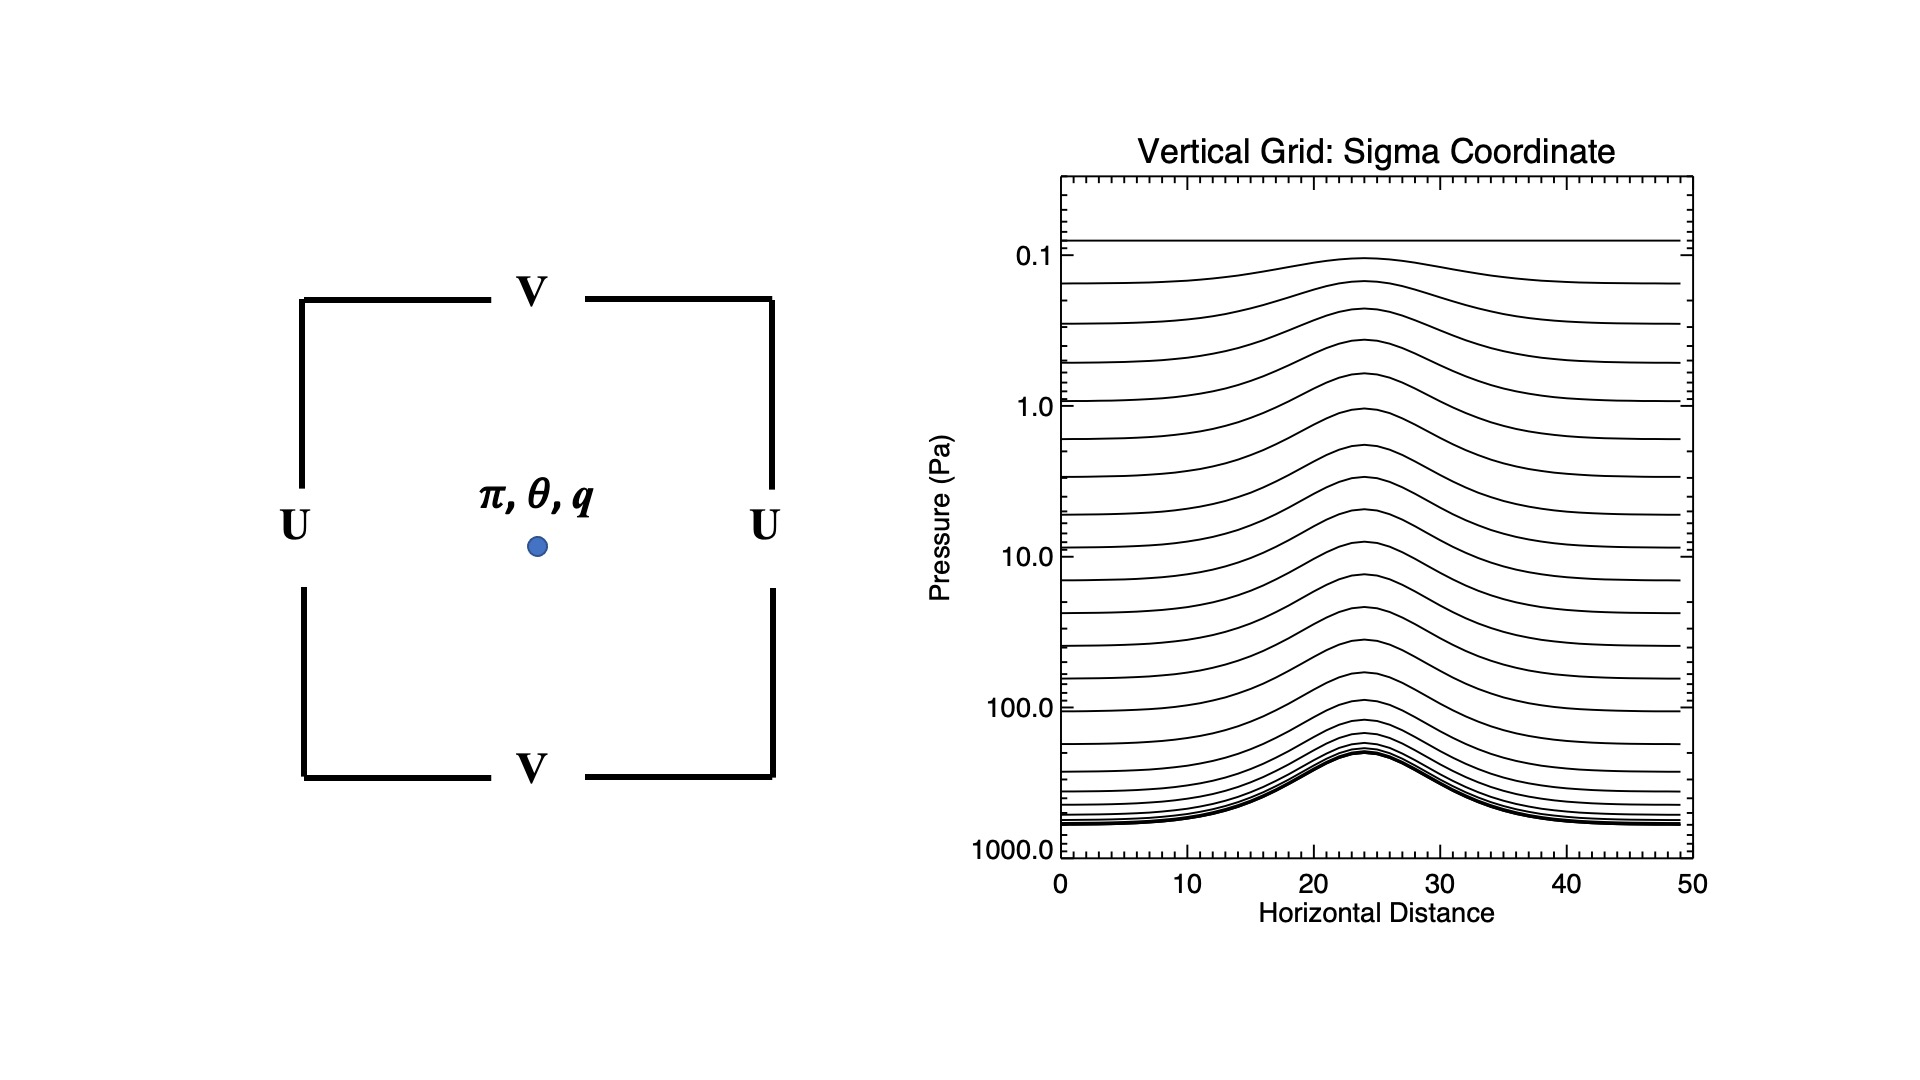|
| --- |
| *Horizontal Arakawaka C-Grid (left) and Vertical Sigma Coordinate Grid (right)* |

### Notes:

- Designed to **conserve energy and enstrophy**
- **Second-order accuracy** for all terms, except **fourth-order accuracy for vorticity advection**
- Dry dynamics only

### References:

- [Suarez and Takacs, 1995](https://gmao.gsfc.nasa.gov/gmaoftp/takacs/gcm/aries.geos.dycore.ver2.ps.Z)
- [Hourdin and Armengaud, 1998](https://journals.ametsoc.org/view/journals/mwre/127/5/1520-0493_1999_127_0822_tuofvm_2.0.co_2.xml)

---

# 3. Physics: Summary of Processes

| No| Process | Primary Subroutine(s) | Timestep |
| :-: | :-: | :-: | :-: |
| [1](#3.1-Physics:-TEMPGR) | Surface CO<sub>2</sub>, Surface and Sub-Surface Temperatures | TEMPGR | Dynamical (~2 min) |
| [2](#3.2-Physics:-Radiation-Code) | Radiative Heating and Cooling | OPTCV, OPTCI, SFLUXV, SFLUXI | Physical (~16 min) |
| [3](#3.3-Physics:-COLDAIR) | Atmospheric CO<sub>2</sub> Condensation | COLDAIR | Physical (~16 min) |
| [4](#3.4-Physics:-NEWPBL) | Planetary Boundary Layer | NEWPBL | Physical (~16 min) |
| [5](#3.5-Physics:-CONVECT) | Convective Adjustment to Ensure Stability | CONVECT | Physical (~16 min) |
| [6](#3.6-Physics:-Atmospheric-Dust-Distribution) | Atmospheric Dust Distribution | FILLTAUCUM, MICROPHYS | Physical (~16 min) |
| [7](#3.7-Physics:-MICROPHYS) | Dust and Cloud Microphysics | MICROPHYS | Physical (~16 min) |
| [8](#3.8-Physics:-Rayleigh-Friction) | Rayleigh Friction | computed in COMP3 |  Physical (~16 min) |

- Subroutines are called from COMP3

---


# 3.1 Physics: TEMPGR

### Purpose:

- Solve surface energy balance equation to calculate surface temperature
- Compute rate of CO<sub>2</sub> condensation at the surface
- Compute subsurface temperatures

|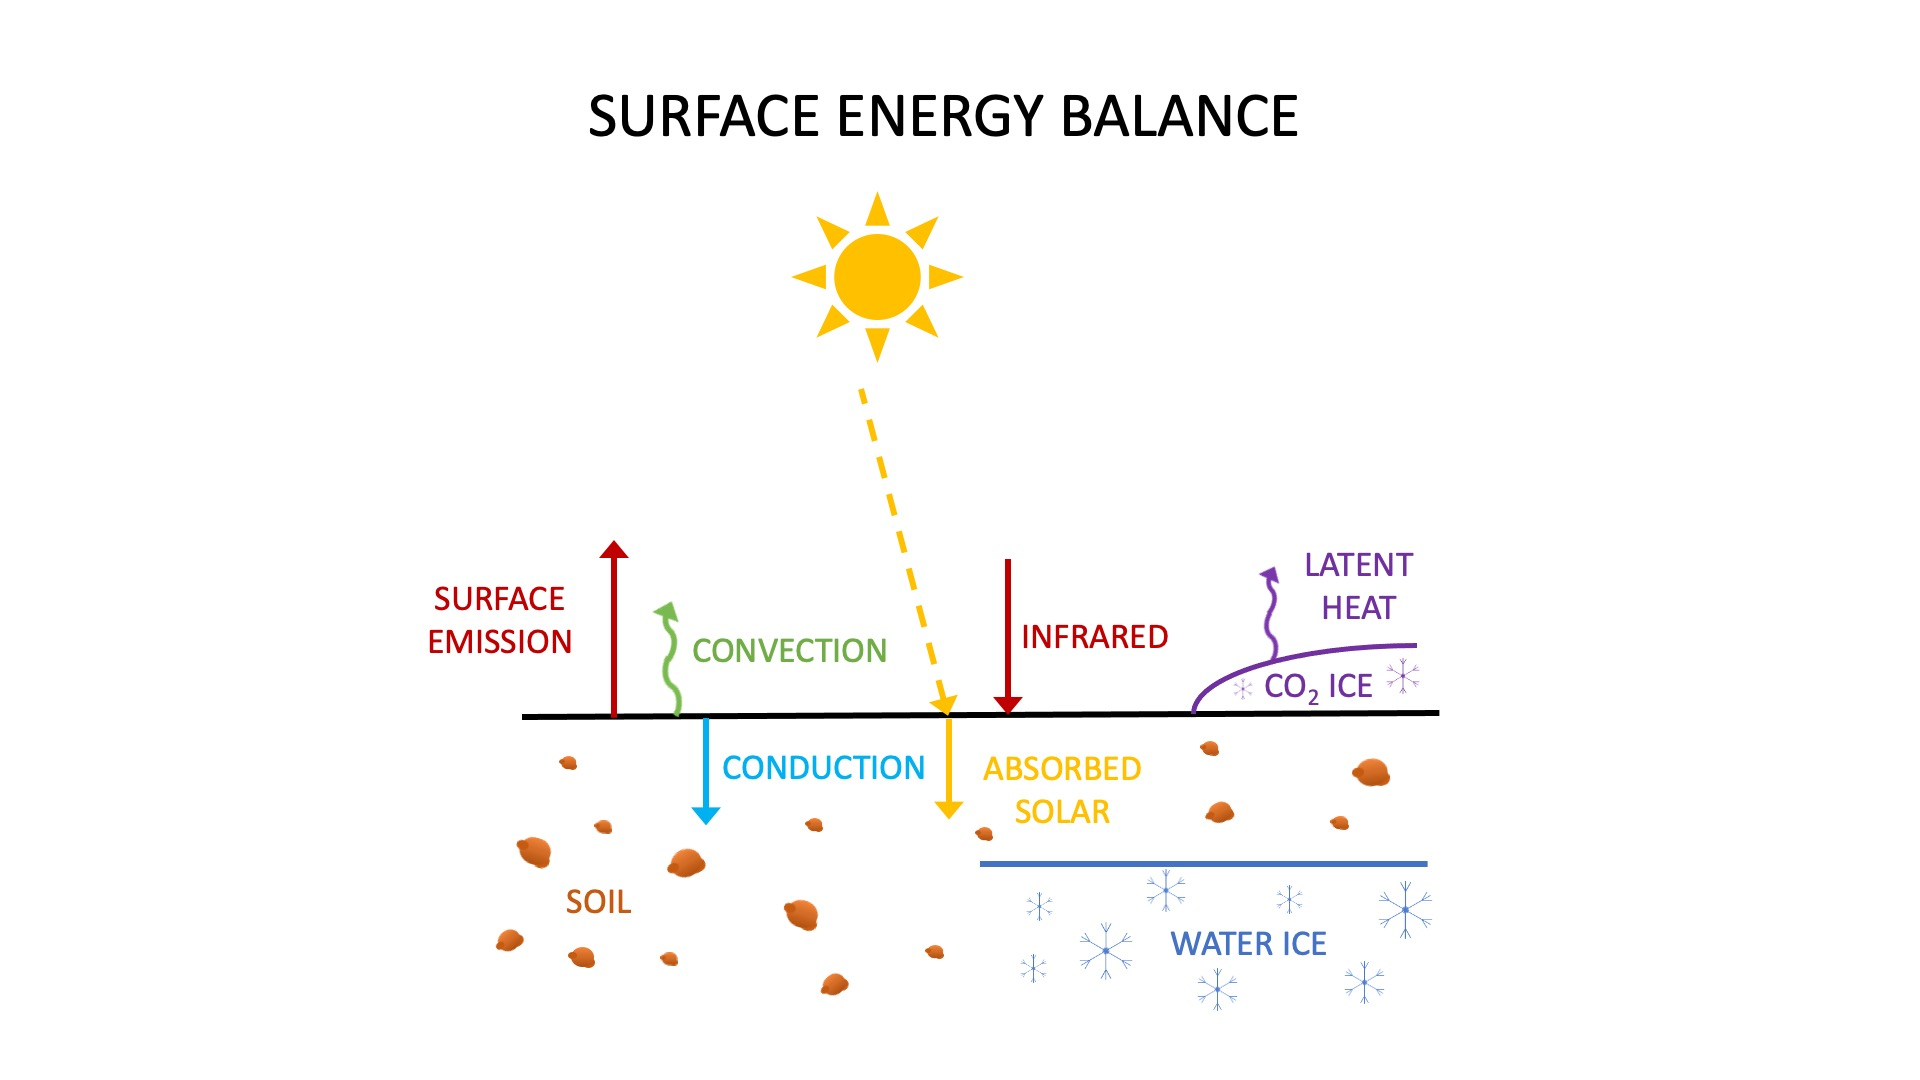|
| --- |


### Surface Temperature (Energy Balance):

$$\epsilon_G \sigma T_G^4-F_{IR}^{\downarrow} -\left(1-A \right)F_s+F_{conv}+F_{cond}=0. $$

- Where:

| Parameter | Meaning | Units |
| --- | --- | --- |
| $$T_G$$ | Ground Temperature | K |
| $$\epsilon_G$$ | Surface Emissivity | None |
| $$F_{IR}^{\downarrow}$$ | Downward IR Flux at the Surface | W m<sup>-2</sup> |
| $$\left(1-A\right)F_s$$ | Absorbed Solar Flux at the Surface | W m<sup>-2</sup> |
| $$F_{conv}$$ | Upward Heat Exchange with the Atmosphere | W m<sup>-2</sup> |
| $$F_{cond}$$ | Downard Conduction into the Surface | W m<sup>-2</sup> |

- Solve for ground temperature ($T_G$) using the Newton-Raphson method




### Surface CO<sub>2</sub> Condensation:

- Compute CO<sub>2</sub> condensation temperature, $T_{\text{CO}_\text{2}}$:

$$T_{\text{CO}_\text{2}}=\frac{3192.48}{23.349-\mathrm{ln}\left(p_s\right)} $$

- Hold $T_G$ at $T_{\text{CO}_\text{2}}$, and use surface energy balance and latent heat of condensation of CO<sub>2</sub>, $L$, to compute rate of CO<sub>2</sub> condensation/sublimation, $\frac{\partial M_{\text{CO}_\text{2}}}{\partial t}$:

$$\frac{\partial M_{\text{CO}_\text{2}}}{\partial t}=\frac{\epsilon_G\sigma T_{\text{CO}_\text{2}}^4-F_{IR}^{\downarrow}-\left(1-A\right)F_s+F_{conv}+F_{cond}}{L}  $$

- Where:

| Parameter | Meaning | Units |
| --- | --- | --- |
| $$L$$ | CO<sub>2</sub> Latent Heat of Condensation | J kg<sup>-1</sup>|
### Subsurface Temperatures (Diffusion Equation):

$$\frac{\partial T_s}{\partial t}=\frac{\partial}{\partial z}\left(\frac{J}{\rho_s c_s}\right)=\frac{\partial^2}{\partial z^2}\left(\frac{T\lambda_s}{\rho_s c_s} \right) $$

- Where:

| Parameter | Meaning | Units |
| --- | --- | --- |
| $$T_s$$ | Soil Temperature | K |
| $$J$$ | Conductive Heat Flux | W m<sup>-2</sup>|
| $$\rho_s$$ | Soil/Ice Density | kg m<sup>-3</sup> |
| $$c_s$$ | Soil/Ice Specific Heat | J kg<sup>-1</sup> K<sup>-1</sup>|
| $$\lambda_s$$ | Soil Conductivity | W m<sup>-1</sup> K<sup>-1</sup>|


- Simple one- or two-component soil model
    - Water ice under soil at high latitudes
- 40 subsurface layers; extends down to ~100 meters
- Solved explicitly with a zero flux bottom boundary condition


## References

- [Haberle and Jakosky, 1991](https://www.sciencedirect.com/science/article/pii/0019103591901008)
- [Haberle et al. 1999](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/1998JE900040)

---

# 3.2 Physics: Radiation Code

### Purpose:
- Compute solar and infrared heating rates (K s<sup>-1</sup>)

|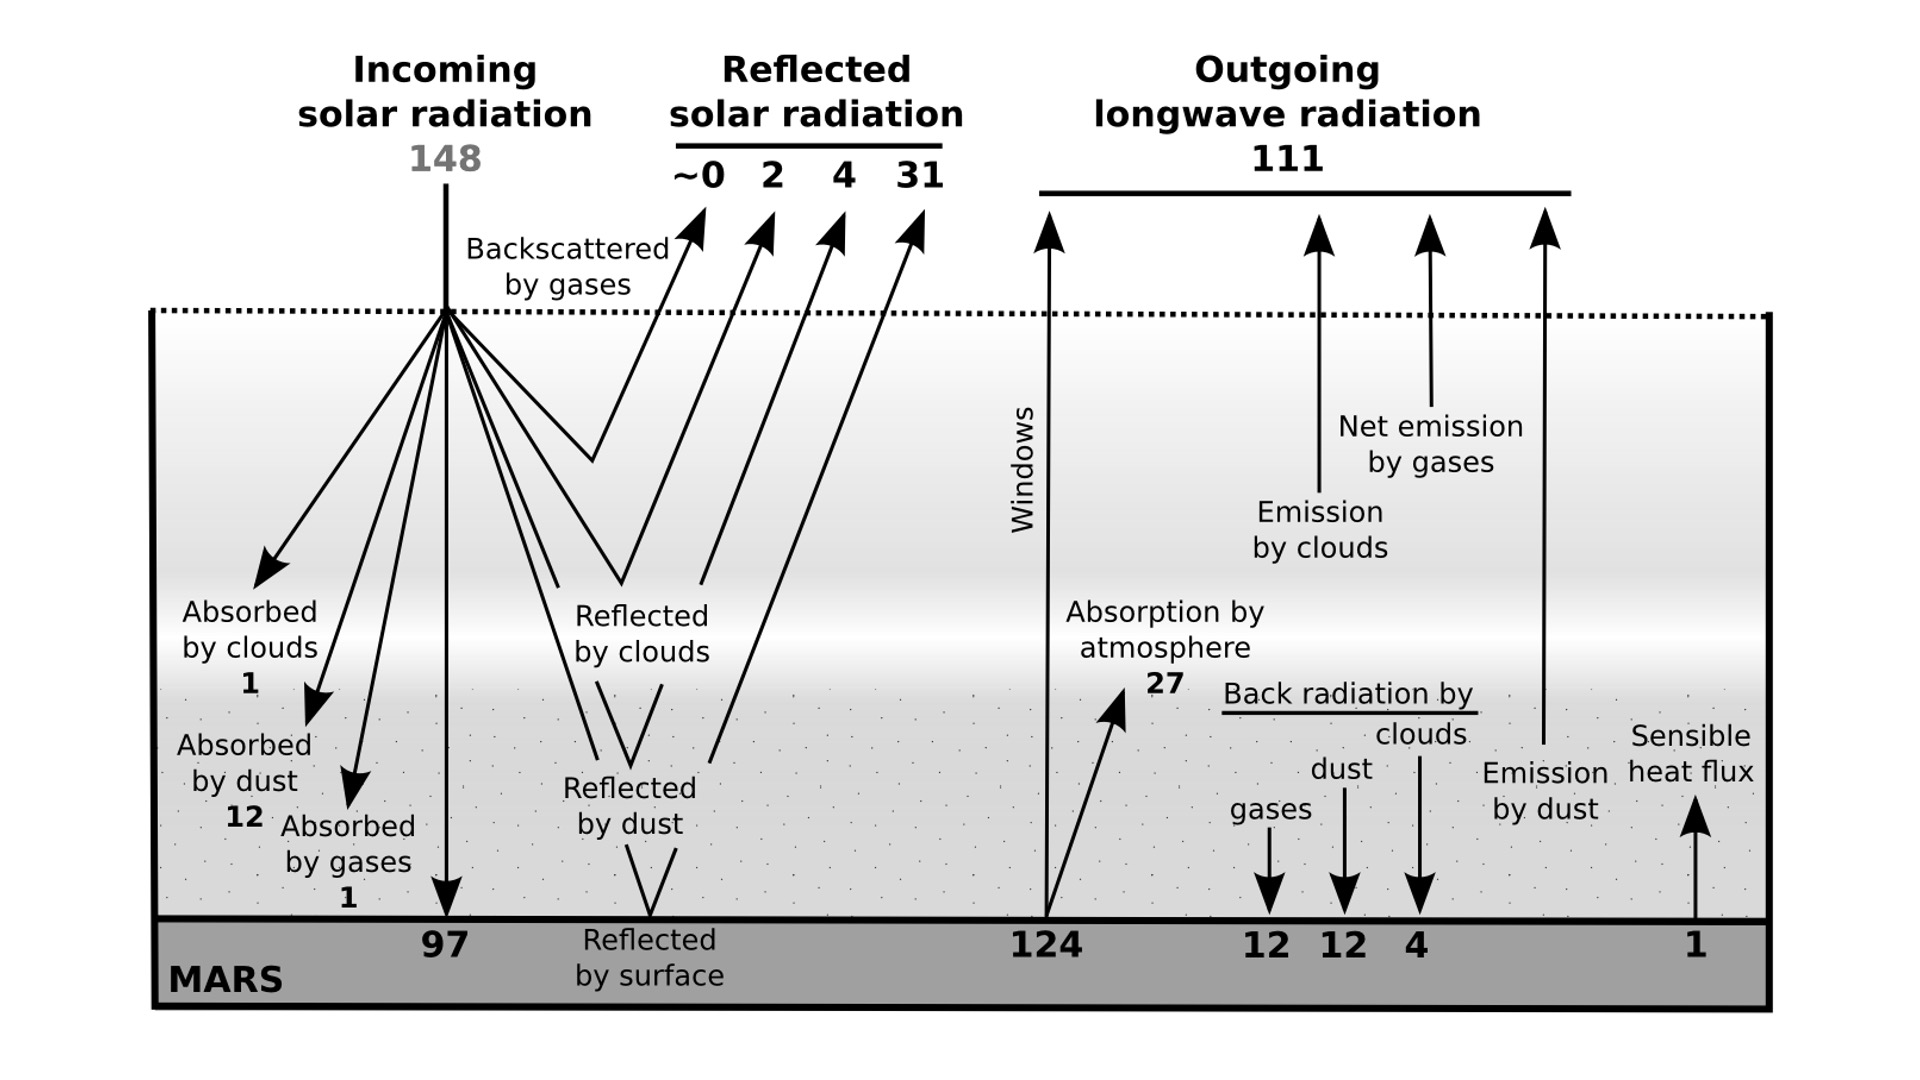|
| --: |
| From [Wolff et al. 2017](https://books.google.ca/books?hl=en&lr=&id=g74pDwAAQBAJ&oi=fnd&pg=PA106&dq=wolff,+m+mars&ots=ZKcrv6ckF2&sig=h8-X46HfeH7GfqQFXuaRmFIlwww#v=onepage&q=wolff%2C%20m%20mars&f=false) |

### Method:
- Compute heating rates from flux divergences
- Compute fluxes from 2-stream code (needs opacities and scattering properties)


**Radiatively active species:** CO<sub>2</sub>, H<sub>2</sub>O, aerosols (dust and ice)

**Opacities:** 

- Correlated k’s for gases (CO<sub>2</sub>/H<sub>2</sub>O)
- Extinction efficiencies for dust and ice

**Scattering properties:** 

- Rayleigh scattering for CO<sub>2</sub>
- Aerosol scattering properties are functions of size and amount of ice. 
    - We use a core/mantle Mie code to generate a lookup table.
    - Refractive indices from [Wolff (2009)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2009JE003350) for dust and [Warren (1984)](https://www.osapublishing.org/ao/fulltext.cfm?uri=ao-23-8-1206&id=27425) for ice.

**Spectral resolution:** 7 bands in visible (0.4-4.5 $\mu$m), 5 bands in IR (4.5-1000 $\mu$m)


| No | GCM Band | Wavelength Interval ($\mu$m) | Wavenumber Interval (cm<sup>-1</sup>) |
| :-: | :-: | :-: | :-: |
| 1 | Vis-7 | 0.24-0.40 | 41666.7 - 25000.0 |
| 2 | Vis-6 | 0.40-0.80 | 25000.0 - 12500.0 |
| 3 | Vis-5 | 0.80-1.31 | 12500.0 - 7633.59 |
| 4 | Vis-4 | 1.31-1.86 | 7633.59 - 5376.34 |
| 5 | Vis-3 | 1.86-2.48 | 5376.34 - 4032.26 |
| 6 | Vis-2 | 2.48-3.24 | 4032.26 - 3086.42 |
| 7 | Vis-1 | 3.24-4.50 | 3086.42 - 2222.22 |
| 8 | IR-5 | 4.50-8.00 | 2222.22 - 1250.00 |
| 9 | IR-4 | 8.00-12.0 | 1250.00 - 833.33 |
| 10 | IR-3 | 12.0-24.0 | 833.33 - 416.67 |
| 11 | IR-2 | 24.0-60.0 | 416.67 - 166.67 |
| 12 | IR-1 | 60.0-1000 | 166.67 - 10.0 |


**Main Routines Involved:** 
- OPTCV(I): sets optical properties
- SFLUXV(I): sums fluxes over spectral intervals
- GFLUXV(I): gets fluxes by solving a tri-diagonal matrix

**Other routines involved:** 
- FILLPT: readies p,T fields for radiation routines
- OPT_DST & OPT_CLD: integrate over size bins to get the scattering properties

## References

- [Toon et al. 1989](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JD094iD13p16287)
- [Haberle et al. 2019](https://www.sciencedirect.com/science/article/pii/S0019103518305761)

---

# 3.3 Physics: COLDAIR

### Purpose:
-  Compute atmospheric CO<sub>2</sub> condensation

|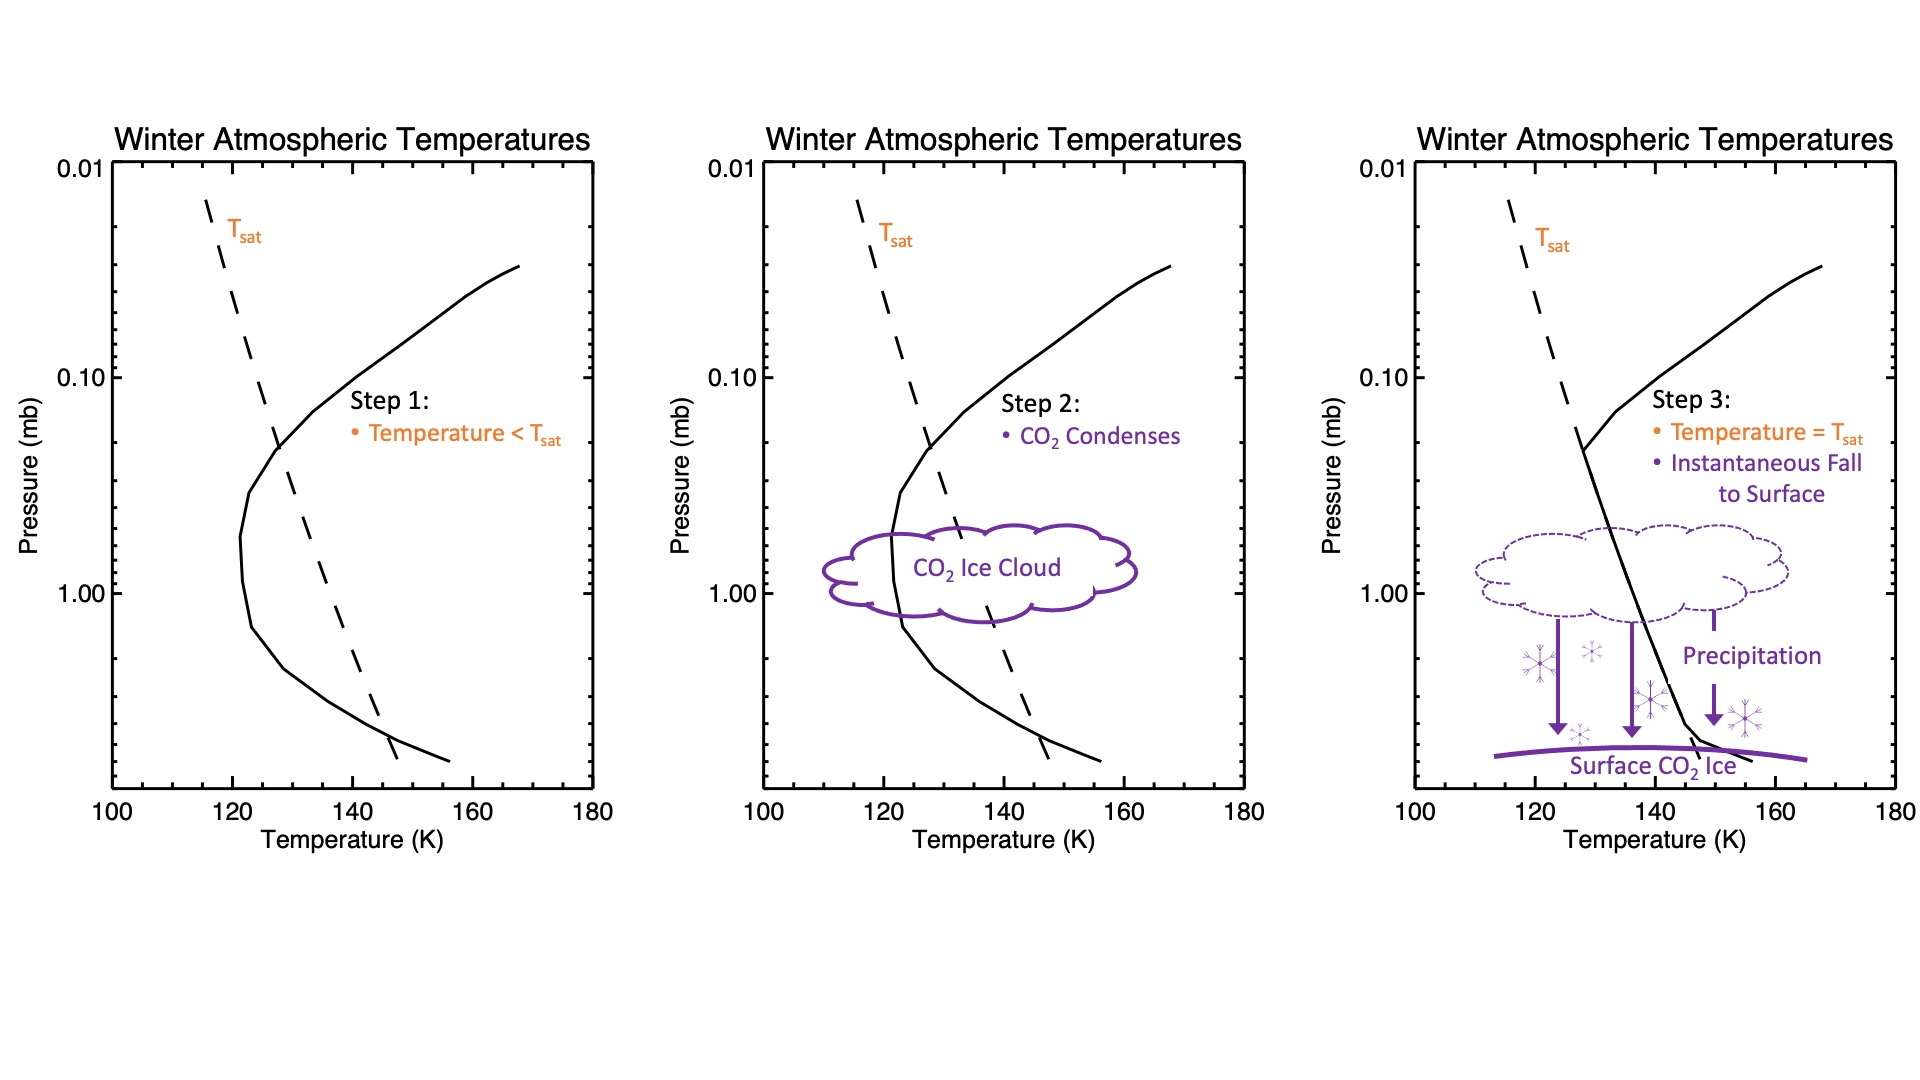|
| --- |

### Methodology:
- Diagnose layers that have temperatures less than CO<sub>2</sub> condensation temperature:

$$T_{\text{CO}_\text{2}}=\frac{3192.48}{23.349-\mathrm{ln}\left(p_l\right)} $$


- In these layers, compute amount of CO<sub>2</sub>, $\delta \text{M}_{\text{CO}_\text{2}}$, that needs to condense to maintain $T_{\text{CO}_\text{2}}$:

$$\delta M_{\text{CO}_\text{2},l} = \frac{100*C_p\left(T_{\text{CO}_\text{2}}-T_l\right)\delta \sigma_l\pi}{gL}  $$

- Where:

| Parameter | Meaning | Units |
| :-: | :-: | :-: |
| $$p_l$$ | Pressure of Layer $l$ | mbars |
| $$C_p$$ | Specific Heat of Air | J kg<sup>-1</sup> K<sup>-1</sup> |
| $$T_l$$ | Temperature of Layer $l$ | K |
| $$\delta \sigma _l$$ | Thickness of Layer $l$ in $\sigma$ coordinates | None|
| $$\pi$$ | $$=p_s-p_{trop}$$ | mbars | 
| $$p_s$$ | Surface Pressure | mbars |
| $$p_{trop}$$ | Pressure at the Top of the Dynamical Domain (Tropopause Pressure) | mbars |
| $$g$$ | Gravity | m s<sup>-2</sup> |
| $$L$$ | CO<sub>2</sub> Latent Heat of Condensation | J kg<sup>-1</sup> |


- Sum $\delta M_{\text{CO}_\text{2}}$ through the column and add to the surface CO<sub>2</sub> budget

- If $T_g>T_{\text{CO}_\text{2}}$, calculate the amount of CO<sub>2</sub> that will remain on surface as $T_g$ cools to $T_{\text{CO}_\text{2}}$

## Reference

- [Pollack et al. 1990](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB095iB02p01447) 

---

# 3.4 Physics: NEWPBL

### Purpose:
- Compute the upward surface turbulent fluxes of heat, momentum, and mass (tracers)
- Vertically mix these in the atmosphere

|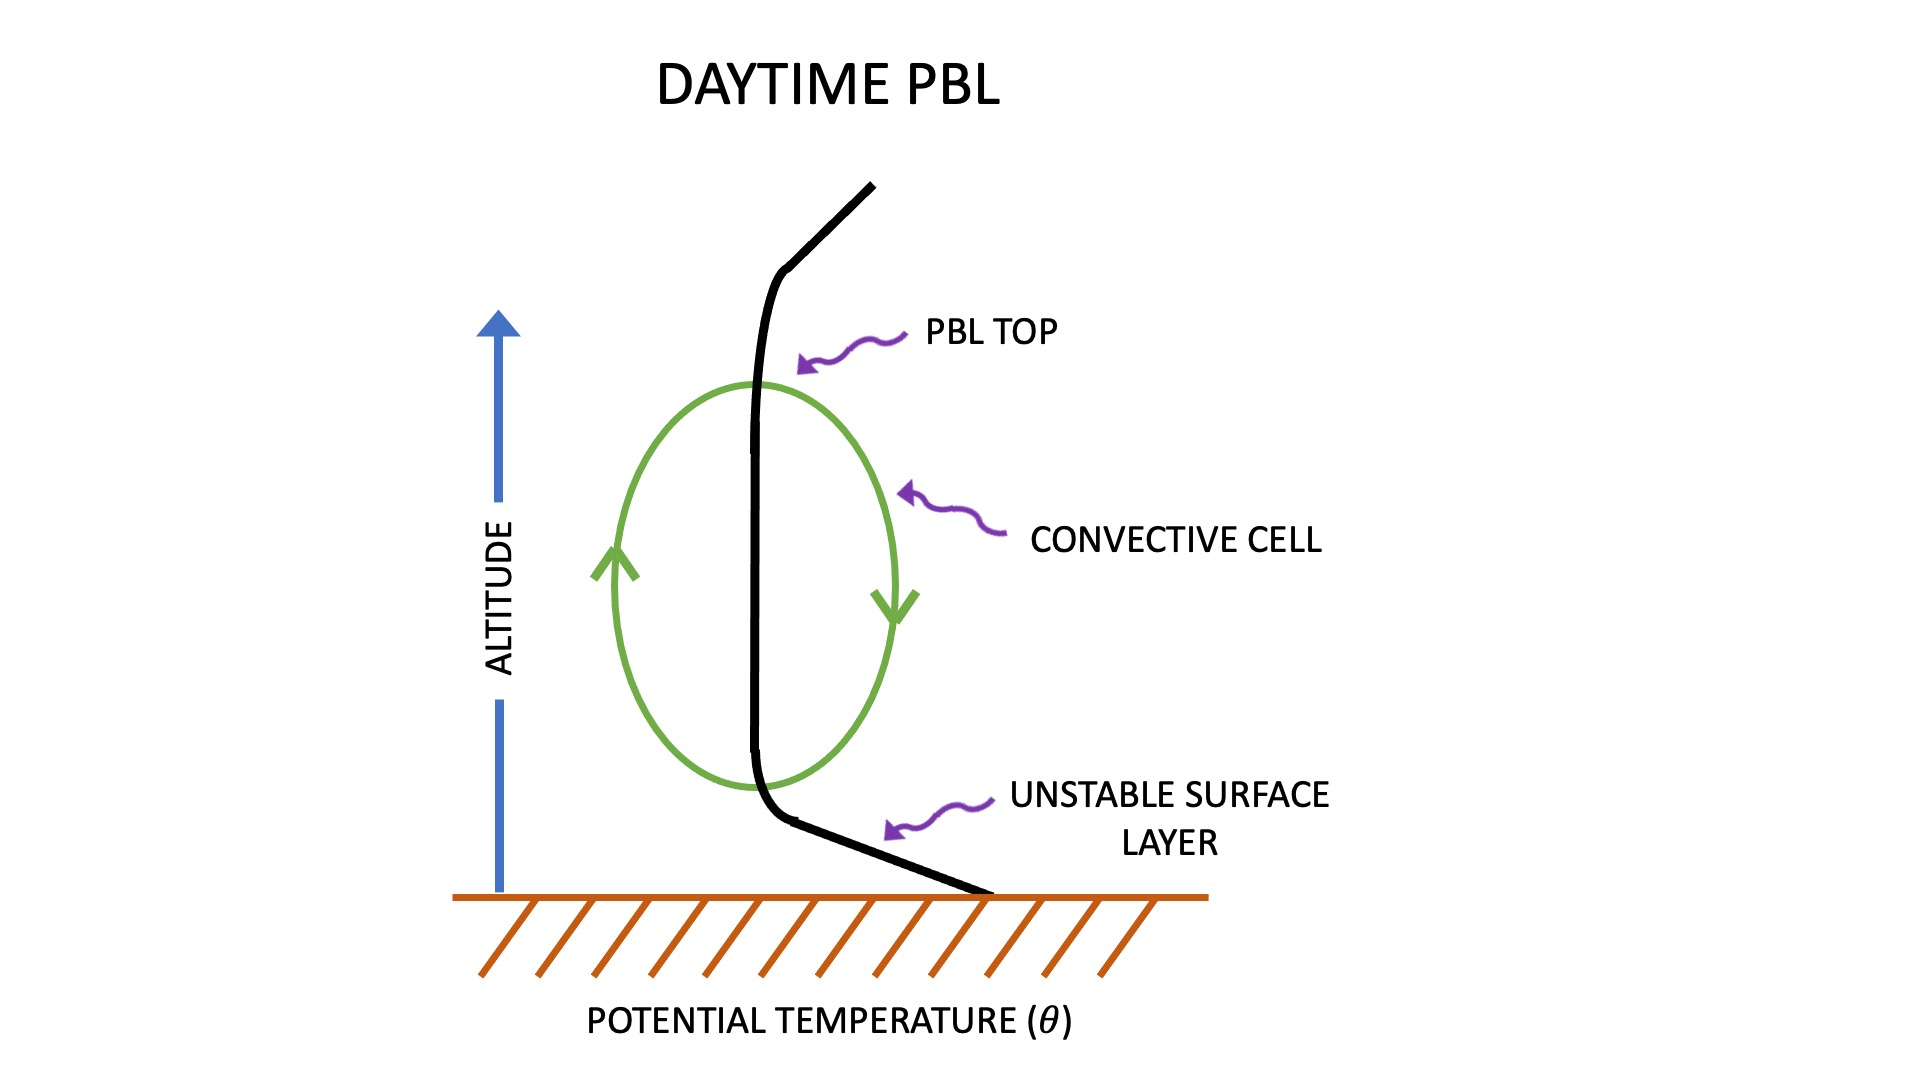|
| --- |

### Basic Physics:
- Surface fluxes calculated from Monin-Obukhov theory (drag laws)
- For example, the heat flux ($F_{conv}$) is:

$$F_{conv}= -\rho c_p c_h u_*\left(T_a - T_g\right)$$

- Where:

| Parameter | Meaning | Units |
| :-: | :-: | :-: |
| $$F_{conv}$$ | Heat Flux | W m<sup>-2</sup> |
| $$\rho$$ | Near-Surface Air Density | kg m<sup>-3</sup> |
| $$c_p$$ | Air Specific Heat | J kg$^{-1}$ K<sup>-1</sup> |
| $$c_h$$ | Heat Drag Coefficient | None |
| $$u_*$$ | Frictional Wind Speed | m s<sup>-1</sup>|
| $$T_a$$ | Near-Surface Air Temperature | K |
| $$T_g$$ | Ground Temperature | K |

- Mixing coefficients are functions of the local Richardson number and are based the [Mellor and Yamada (1982)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/RG020i004p00851?casa_token=LLfodfXZmxkAAAAA:1ySdWtwyab3XBgg4OPyDSYjv8v7AxEVNdol_9DKqAOpZKbi0MBXjjwHsV9FGLf5YcecbaODRRY4gNrCj-Q) Level 2 scheme
- The Richardson number, $R_i$ is given by:

$$R_i= \frac{\frac{g}{\theta}\frac{\partial \theta}{\partial z}}{\left(\frac{\partial V}{\partial z}\right)^2}$$

- Where:

| Parameter | Meaning | Units |
| :-: | :-: | :-: |
| $$g$$ | Gravity | m s<sup>-2</sup> |
| $$\theta$$ | Potential Temperature | K |
| $$V$$ | Wind Speed | m s<sup>-1</sup> |
| $$z$$ | Altitude | m |

### Methodology:
- Solves a diffusion equation with an arbitrary vertical co-ordinate
- Scheme can be implicit or explicit (we always run with the implicit option)

### Notes:
- Does not completely eliminate instabilities (i.e., it is not a convective adjustment scheme)
- Mixing effectively shuts off when $R_i$ $>$ 0.25 
- Water vapor tracer is mixed in NEWPBL with the heat coefficients; other tracers are mixed in the sedimentation routine.

<div style="page-break-after: always;"></div>

### References:

- [Haberle et al. 1993](https://journals.ametsoc.org/view/journals/atsc/50/11/1520-0469_1993_050_1544_ablmfm_2_0_co_2.xml)
- [Haberle et al. 1999](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/1998JE900040)

---

# 3.5 Physics: CONVECT

### Purpose:

- Remove any remaining superadiabatic atmospheric layers after NEWPBL.
- Determine the potential temperature within the convective layer ($\theta_{c}$).
- Determine the pressure of the top of the convective layer that exists above the surface (i.e., pressure at the top of the boundary layer, $p_{c}$).

| 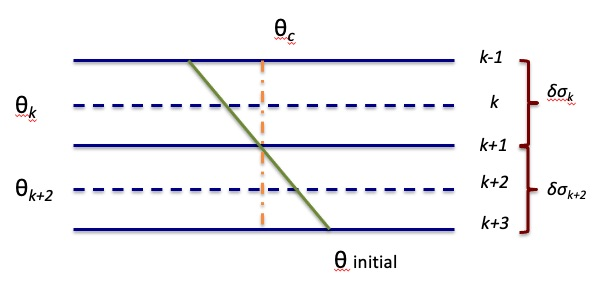 |
| --- |

### Method:
- Stabilize regions where potential temperature decreases with height by conserving the total heat energy.

$$\theta_c = \frac{\left(p_k\right)^\kappa \delta \sigma_k \theta_k + \left(p_{k+2}\right)^\kappa \delta \sigma_{k+2}\theta_{k+2}}{\left(p_k\right)^\kappa \delta \sigma_k + \left(p_{k+2}\right)^\kappa \delta \sigma_{k+2}}$$

- Where:

| Parameter | Meaning | Units |
| :-: | :-: | :-: |
| $$p$$ | Pressure | mbars |
| $$\delta \sigma$$ | Layer Thickness in $\sigma$ Coordinates | None |
| $$\theta$$ | Potential Temperature | K |
| $$\kappa$$ | $$\frac{R_{gas}}{c_p}$$ | None |
| $$R_{gas}$$ | Gas Constant for CO<sub>_2</sub> |  J kg<sup>-1</sup> K<sup>-1</sup> |
| $$c_p$$ | Specific Heat | J kg<sup>-1</sup> K<sup>-1</sup> |

- Instantaneously mix all tracers in unstable regions.



### References:

- [Pollack et al. 1990](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB095iB02p01447) 
- [Pollack et al. 1981](https://journals.ametsoc.org/view/journals/atsc/38/1/1520-0469_1981_038_0003_amgcew_2_0_co_2.xml)

---

# 3.6 Physics: Atmospheric Dust Distribution

### Purpose:

- Provide multiple options for determining the atmospheric dust distribution 
- Hierarchy of dust treatment options, from simple to complex
- Important for including the radiative forcing from dust

### Methods

- **Option 1: Fully Prescribed**
    - Horizontal:  Globally constant or based on an observation-based dust opacity map
    - Vertical: Prescribed using Conrath profiles or similar ([Conrath, 1975](https://www.sciencedirect.com/science/article/pii/0019103575901566))
    - Lifting: NONE

|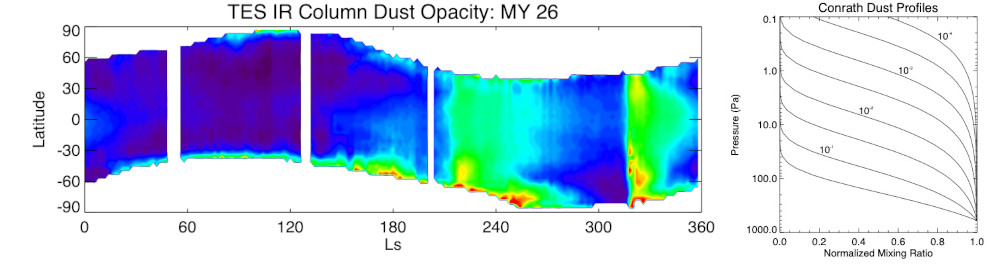|
| --- |

- **Option 2: Semi-Prescribed (Tracking)**
    - Horizontal: Based on a observation-based dust opacity map
    - Vertical: Self-consistenly determined from transported dust tracers
    - Lifting: As needed to track desired horizontal distribution (usually a map)

|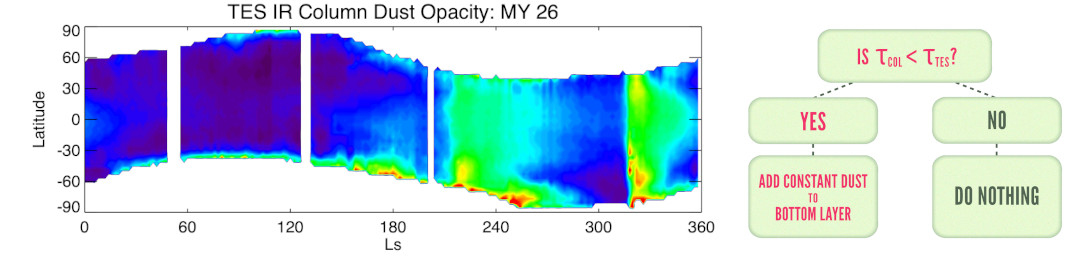|
| --- |

- **Option 3: Fully Interactive**
    - Horizontal: Self-consistently determined by predicted lifting and transport
    - Vertical: Self-consistenly determined from transported dust tracers
    - Lifting: Based on physical dust lifting parameterizations (usually wind stress and dust devils)



|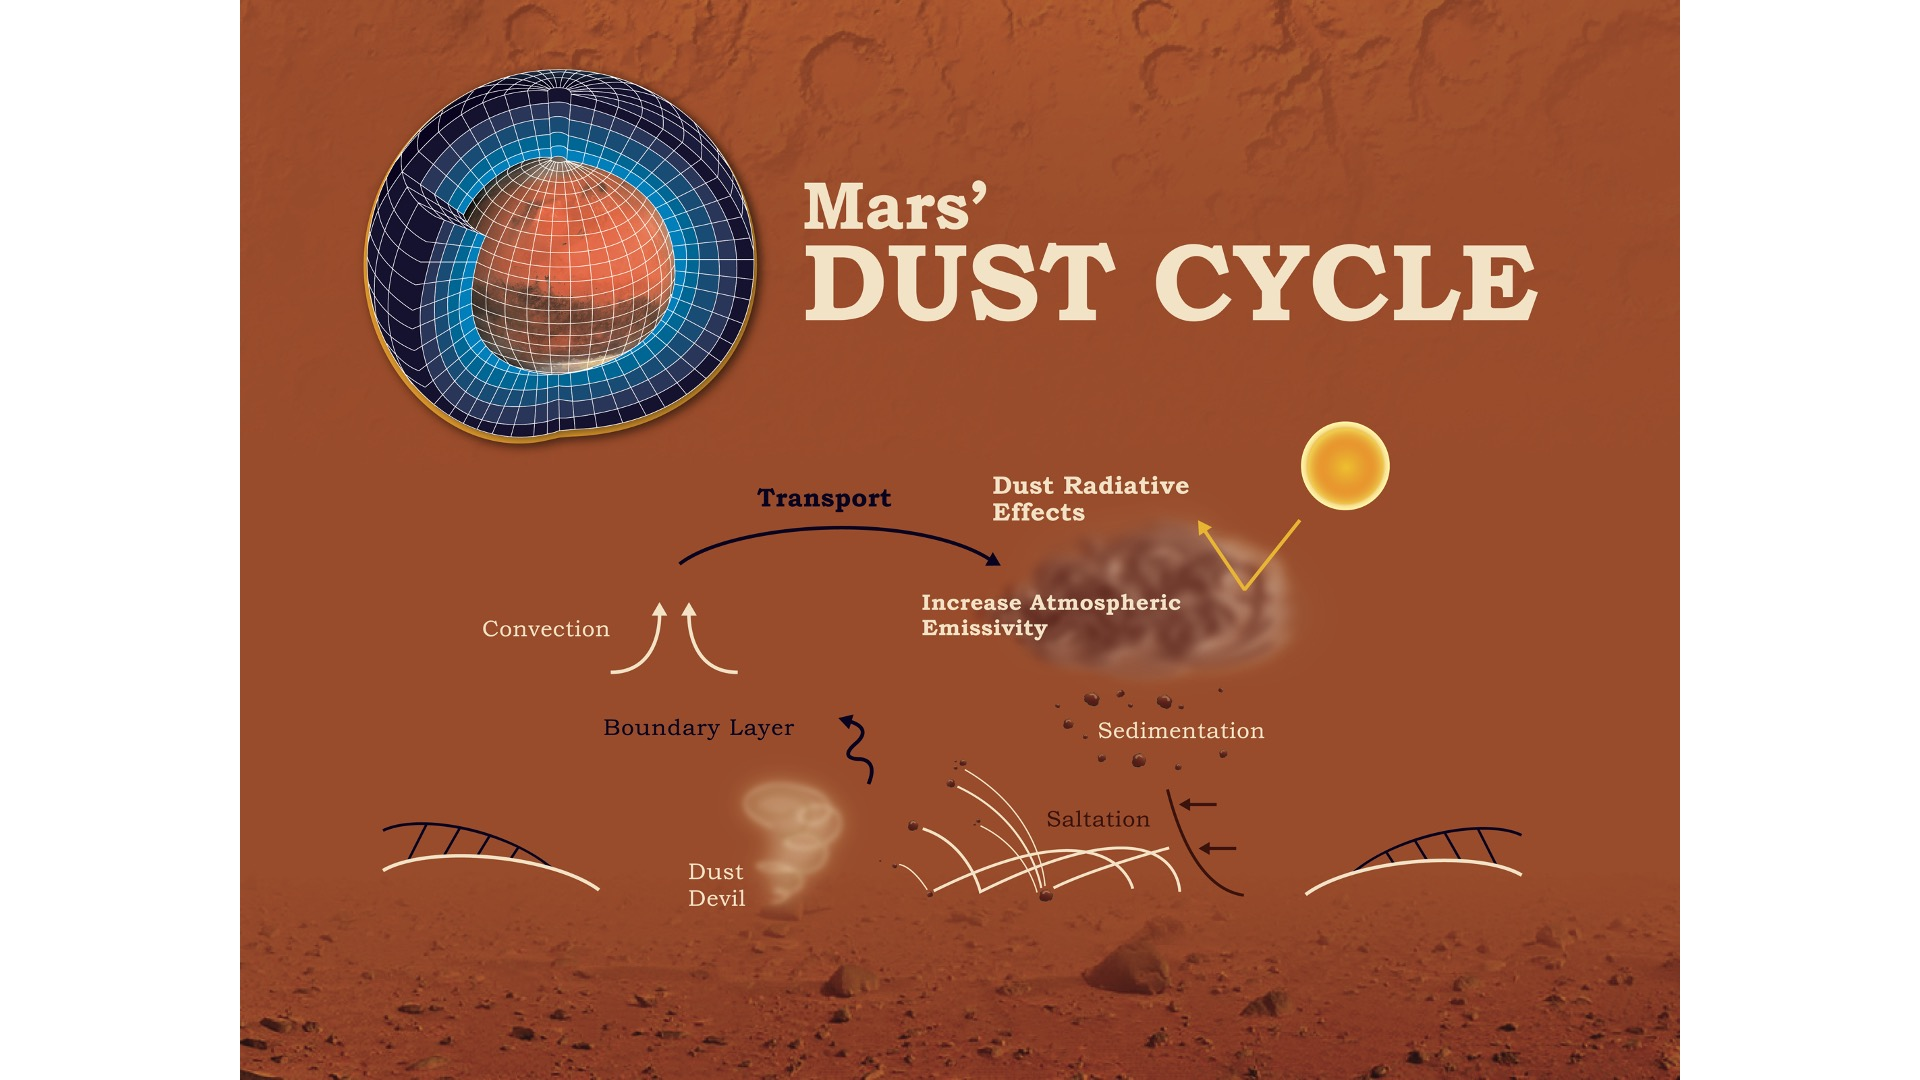|
| -- |

### References:

- [Haberle et al. 2019](https://www.sciencedirect.com/science/article/pii/S0019103518305761)
- [Kahre et al. 2015](https://www.sciencedirect.com/science/article/pii/S0019103514003832)

---

# 3.7 Physics: MICROPHYS

### Purpose:
- Compute dust injection, aerosol sedimentation, and cloud nucleation and growth

|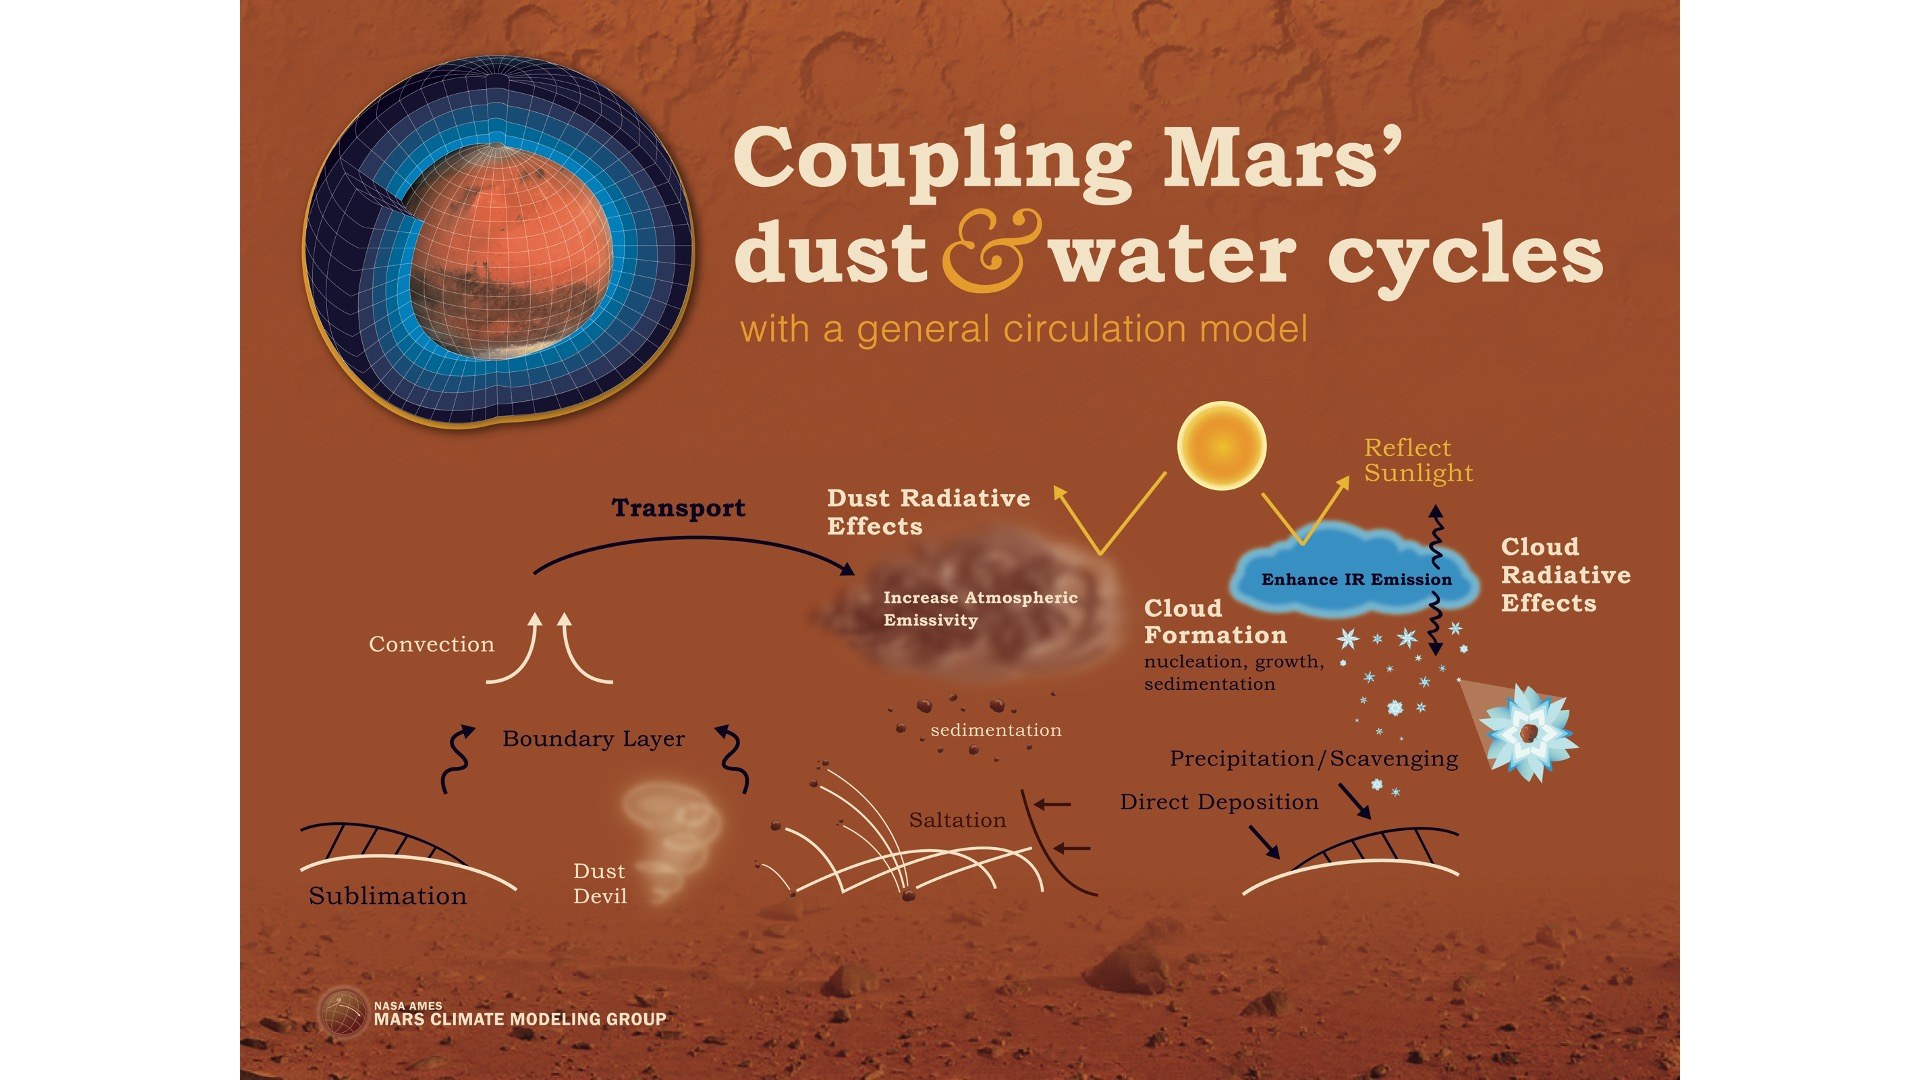|
| --- |

### Basic Physics:
- Multiple dust injection methods, including dust tracking, dust devil lifting and wind stress lifting
- Cunningham-Stokes gravitational sedimentation
- Cloud nucleation and growth as described in Haberle et al. ([2019](https://www.sciencedirect.com/science/article/pii/S0019103518305761)) and Montmessin et al. ([2002](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2001JE001520)/[2004](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2004JE002284))
- Transported dust and clouds are optionally radiatively active

### Methodology: 

#### Moment Method

- Assume particle size distribution is log-normal

$$ n\left(r \right) = \frac{N_o}{r \sigma_o \sqrt{2\pi}}\mathrm{exp}\left[\frac{1}{2}\left(\frac{\mathrm{ln}\left(r/r_o\right)^2}{\sigma_o}\right)\right]$$

- Where:

| Parameter | Meaning | Units |
| :-: | :-: | :-: |
| $$n\left(r \right)$$ | Number of Particles of Radius $r$ | # per unit volume per unit radius |
| $$N_o$$ | Total Number of Particles | # per unit volume |
| $$r_o$$ | Median Radius | m |
| $$\sigma_o$$ | Standard Deviation | none |


- It follows that the total number of particles between $r_{\mathrm{min}}$ and $r_{\mathrm{max}}$ is:

$$ N= \int_{r_{min}}^{r_{max}} n\left(r\right) dr = \frac{N_o}{2}\left[\mathrm{erf}\left(\frac{\mathrm{ln}\left(r_{max}/r_o\right)}{\sqrt{2\pi \sigma_o}} \right)-\mathrm{erf}\left(\frac{\mathrm{ln}\left(r_{min}/r_o\right)}{\sqrt{2\pi \sigma_o}}  \right)\right]$$

- Separately, the total mass of the distribution ($M_o$) can be calculated from $r_o$:

$$ M_o = \frac{4}{3} \pi \rho \int r^3 n\left(r\right) = \frac{4}{3}\pi \rho N_o r_o^3 \mathrm{exp}\left(\frac{9}{2}\sigma_o^2 \right)$$

- Solving for $r_o$:

$$ r_o = \left[\frac{3M_o}{4\pi \rho N_o}\right]^{1/3}\mathrm{exp}\left(-\frac{3}{2}\sigma_o^2 \right)$$

- Thus, the distribution can be fully represented by $M_o$, $N_o$, and $\sigma_o$

- We assume $\sigma_o$ is a constant, so only $M_o$ and $N_o$ are carried as tracers.

- Taking further advantage of the properties of log-normal distributions, many representative particle radii can be calculated

| Process | Symbol | Formula |
| :-: | :-: | :-: | 
| Nucleation | $r_o$ | $$\left(\frac{3M_o}{4\pi \rho N_o} \right)^{1/3}\mathrm{exp}\left(-1.5\sigma_o^2 \right)$$ |
| Growth | $r_v$ | $$r_o\mathrm{exp}\left(1.5\sigma_o^2\right)$$ | 
| Mass Sedimentation | $r_{sed,m}$ | $$r_o\mathrm{exp}\left(4.5\sigma_o^2\right)$$ | 
| Number Sedimentation | $r_{sed,n}$ | $$r_o\mathrm{exp}\left(1.5\sigma_o^2\right)$$ |
| Opacity (total cross-section) | $r_s$ | $$r_o\mathrm{exp}\left(\sigma_o^2\right)$$ | 
| Scattering properties | $r_{eff}$ | $$r_o\mathrm{exp}\left(2.5\sigma_o^2\right)$$ | 


- We use the most appropriate representative radius for each physical process

#### Tracers

- The GCM carries an array (`QTRACE`) with 6 atmospheric tracers:

| Tracer | Units | Array Index | Index Name |
| :-: | :-: | :-: | :-: |
| Dust Mass | kg kg<sup>-1</sup> | 1 | ima_dt |
| Dust Number | # kg<sup>-1</sup> | 2 | inb_dt |
| Water Cloud Mass | kg kg<sup>-1</sup> | 3 | ima_cld |
| Water Cloud Number | # kg<sup>-1</sup> | 4 | inb_cld |
| Dust Core Mass | kg kg<sup>-1</sup> | 5 | ima_cor |
| Water Vapor Mass | kg kg<sup>-1</sup> | 6 | ima_vap |

- An array of 6 surface tracers (`QCOND`) is also carried, but some indices are empty:

| Tracer | Units | Array Index | Index Name |
| :-: | :-: | :-: | :-: |
| Dust Mass Deposited | kg m<sup>-2</sup> | 1 | ima_dt |
| EMPTY | N/A | 2 | N/A |
| Water Cloud Mass Deposited | kg m<sup>-2</sup> | 3 | ima_cld |
| EMPTY | N/A | 4 | N/A |
| Dust Core Mass Deposited | kg m<sup>-2</sup> | 5 | ima_cor |
| Water Mass Reservoir | kg m<sup>-2</sup> | 6 | ima_vap |



#### Processes

##### Dust Injection:  **DUST_UPDATE**

- Computes flux of dust from the surface to the atmosphere
- Assumes a log-normal distribution with $r_{eff}$ = 2.0 $\mu$m
- Adds to mass and number moments for dust

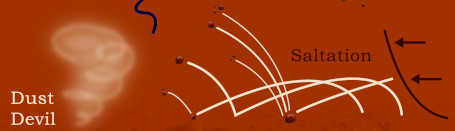

##### Sedimentation: **SEDIM**

- Uses mass and number weighted mean radii of dust and cloud particles
- Computes fall velocities for each type of particle
- Update column tracer arrays for all tracers (except H<sub>2</sub>O vapor)

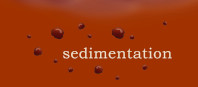

##### Cloud Nucleation and Growth:  **NUCLEACOND**

- Nucleation:
    - Expands dust mass and number moments into bin
    - Computes nucleation rate for each bin
    - Sums over bins to compute total mass and number of nucleated dust particles
    
- Growth:
    - Compute volume mean radius for cloud particles
    - Computes growth rate and converts to cloud mass exchange
    - Updates cloud mass (and cloud number if cloud particles sublimate completely)
 
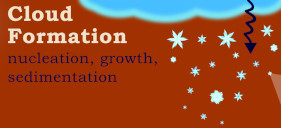
    
### References:

- [Haberle et al. 2019](https://www.sciencedirect.com/science/article/pii/S0019103518305761)
- [Montmessin et al. 2004](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2004JE002284)
- [Montmessin et al. 2002](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2001JE001520)

---

# 3.8 Physics: Rayleigh Friction

### Purpose:

- To damp waves as they approach the model top to minimize reflections from the top boundary

### Method:

- Damp zonal ($U$) and meridional ($V$) winds with a rate of change that is proportional to their magnitude:

\begin{align}
\frac{\partial U}{\partial t}=-\frac{U}{\tau}\\
\frac{\partial V}{\partial t}=-\frac{V}{\tau}\\
\end{align}

- where $\tau$ is a damping timescale (~1 day)
- Convert lost kinetic energy into heat and update potential temperature of affected layers
- Applied to the top 3 model layers
- Negligible effect on the lower atmosphere

### Reference:

- [Pollack et al. 1990](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB095iB02p01447)

[^](#3.-Physics:-Summary-of-Processes)

---

# 4. Horizontal Grid Structure


### Horizontal: Latitude-Longitude Grid 

- Arakawa C-Grid Staggered Grid Structure
- Nominal horizontal resolution is 5<sup>o</sup> latitude by 6<sup>o</sup> longitude
    > While it is possible to change the horizontal resolution, it is not straightforward.  Please ask us about it before you try it!
- Modified pressure ($\pi=p-p_{trop}$, where $p_{trop}$ is the tropopause pressure), potential temperature ($\theta$), tracers ($q$) carried at grid mid-points
- Winds are carried at grid boundaries
    - Zonal winds ($U$) staggered E/W
    - Meridional winds ($V$) staggered N/S

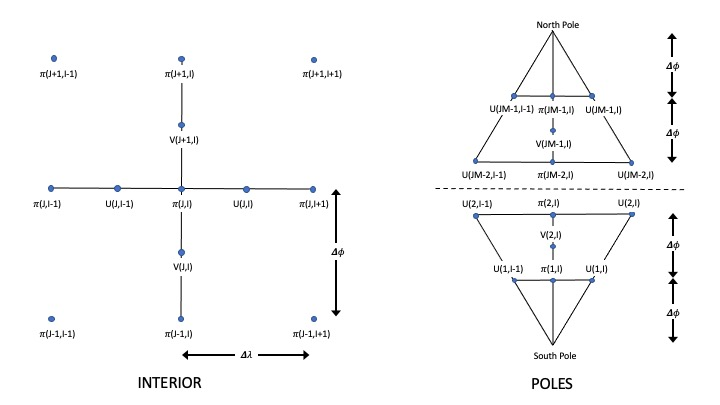

Latitude ($\phi_j$): $\Delta\phi = \frac{180.0}{JM}$, where $JM$ is the number of latitude grid points (nominally 36).

| Equation | Range |
| --- | --- |
| $$\phi_j(\pi,T) = -90.0 + \Delta\phi\cdot J$$ | $$J = 1,JM-1$$ |
| $$\phi_j(U) = -90.0 + \Delta\phi\cdot J$$ | $$J = 1,JM-1$$ |
| $$\phi_j(V) = (-90.0+1.5\cdot\Delta\phi) + \Delta\phi\cdot(J-2)$$ | $$J = 2,JM-1$$ |


Longitude ($\lambda_i$): $\Delta\lambda=\frac{360.0}{IM}$, where $IM$ is the number of longitude grid points (nominally 60).

| Equation | Range |
| --- | --- |
| $$\lambda_i(\pi,T) = -180.0 + \Delta\lambda\cdot(I-1)$$ | $$I = 1,IM$$ |
| $$\lambda_i(U) = (-180.0+0.5\cdot\Delta\lambda) + \Delta\lambda\cdot(I-1) $$ | $$I = 1,IM$$ |
| $$\lambda_i(V) = -180.0 + \Delta\lambda\cdot(I-1)$$ | $$I = 1,IM$$ |

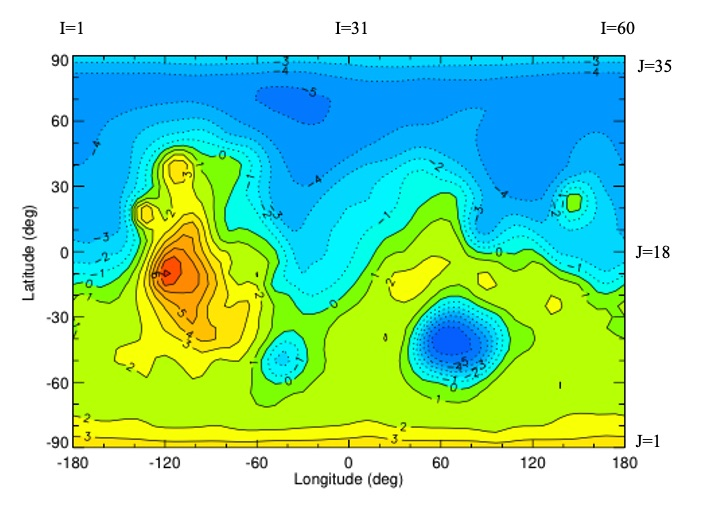
    
---

# 5. Vertical Grid Structure

### Sigma Coordinate (Terrain Following)

- Simplifies the handling of the lower boundary in the presence of topography.
- $\sigma$ is defined by: 

$$\sigma = \frac{\left(p-p_{trop}\right)}{\left(p_s-p_{trop}\right)}$$

- Where:

| Parameter | Meaning | Units |
| :-: | :-: | :-: |
| $$p$$ | Pressure | mbars |
| $$p_{trop}$$ | Tropopause Pressure (Top of the Dynamical Domain; CONSTANT) | mbars |
| $$p_s$$ | Surface Pressure | mbars |

- The $\sigma$ surfaces are fixed in a GCM simulation.  Thus, the pressure at a given layer ($l$) at any time can be calculated: by:

$$p_l = (p_{s}-p_{trop}) \cdot\sigma_l + p_{trop}$$

#### GCM Layering: 

- N layers (nominally 24) in the vertical, with both midpoints and boundaries available for calculations
    - Vertical resolution ranging from: ~10 meters near the surface to ~10 kilometers aloft
    > While it is possible to change the vertical resolution, it is not straightforward.  Please ask us about it before you try it!

#### Radiation Code Layering:
  
- N+1 layers
    - Layer midpoints line up with GCM layer boundaries
    - N+1 layer is a half-layer just above the surface, to simplify including the bottom temperature boundary condition.
    
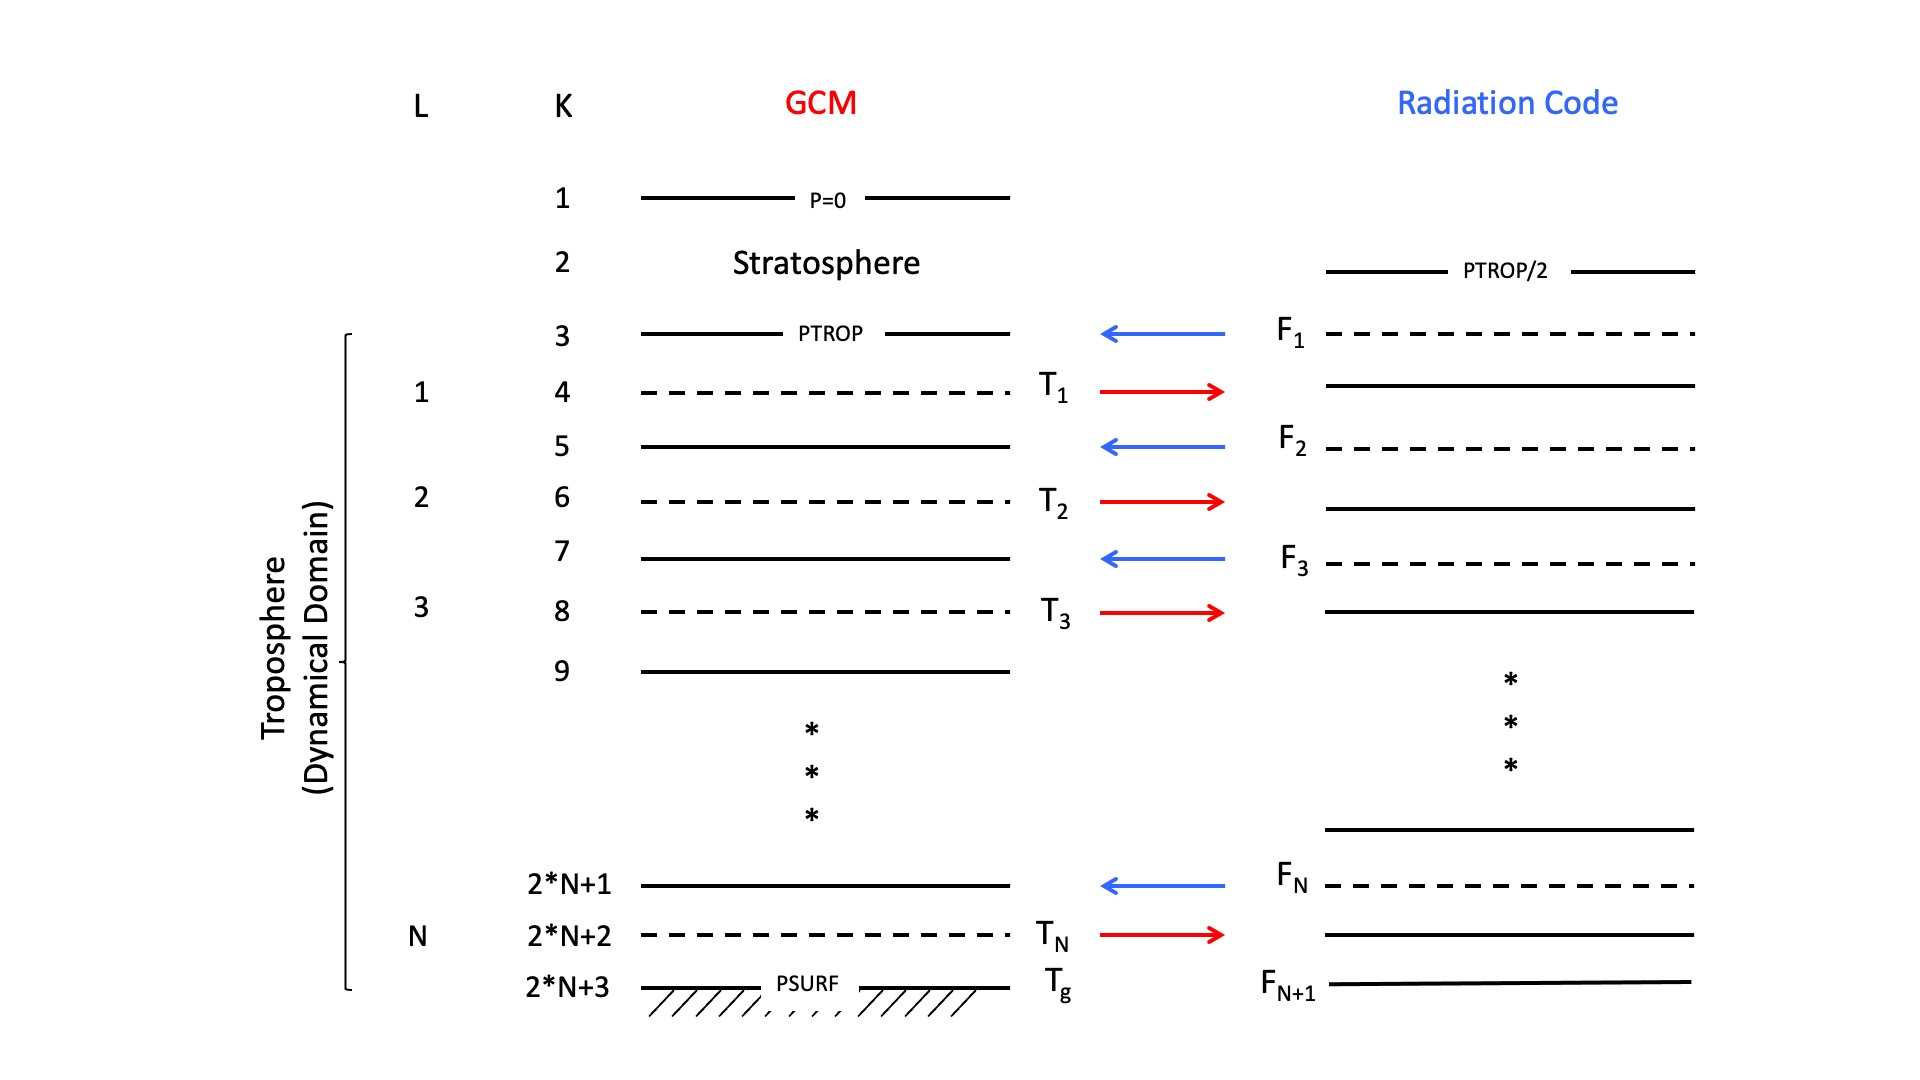

---

# 6. Time Stepping (NEWSTEP)

## Called every dynamical timestep (~2 min).

### Purpose:

- Update all atmospheric fields ($\pi$, $\theta$, U, V, QTRACE)
- Update surface tracer field (QCOND)
- Apply Robert time filter and Shapiro spatial filters (but not on QTRACE)

### Method:

- Use leap frog scheme in combination with a Robert time filter ($\alpha$ = 0.05) to suppress computational mode.
- Note that potential temperature ($\theta$) and tracers ($q$) are pressure-weighted, while the other fields are not.

| Field | Advance Fields to Future Timestep (t+1) | Filter Current Timestep (t) 
| :-: | :-: | :-: | 
| Pressure | $$\pi_{t-1}+\frac{\partial \pi}{\partial t}2\text{dt}$$ | $$ \alpha \frac{\pi_{t-1}+\pi_{t+1}}{2}+\left(1-\alpha \right)\pi_t$$ |
| Potential Temperature | $$\frac{1}{\pi_{t+1}}\left[\pi_{t-1}\theta_{t-1}+\frac{\partial \pi \theta}{\partial t}2\text{dt}\right]$$ | $$\frac{1}{\pi_t}\left[\alpha \frac{\left(\pi_{t-1}\theta_{t-1}+\pi_{t+1} \theta_{t+1}\right)}{2}+\left(1-\alpha \right)\pi_t \theta_t\right]$$ |
| Zonal Wind | $$u_{t-1}+\frac{\partial u}{\partial t}2\text{dt}$$ | $$\alpha \frac{\left(u_{t-1}+u_{t+1}\right)}{2}+\left(1-\alpha \right) u_t$$ |
| Meridional Wind | $$v_{t-1}+\frac{\partial v}{\partial t}2\text{dt}$$ | $$\alpha \frac{\left(v_{t-1}+v_{t+1}\right)}{2}+\left(1-\alpha \right) v_t$$ |
| Tracers | $$\frac{1}{\pi_{t+1}}\left[\pi_{t-1}q_{t-1}+\frac{\partial \pi q}{\partial t}2\text{dt}\right]$$ | $$\frac{1}{\pi_t}\left[\alpha \frac{\left(\pi_{t-1}q_{t-1}+\pi_{t+1} q_{t+1}\right)}{2}+\left(1-\alpha \right)\pi_t q_t\right]$$ |
| Surface Tracers | $$qc_{t-1}+\frac{\partial qc}{\partial t}2\text{dt}$$ | $$\alpha \frac{\left(qc_{t-1}+qc_{t+1}\right)}{2}+\left(1-\alpha \right) qc_t$$ |

---




# 7. Code Architecture

### Full Code Architecture

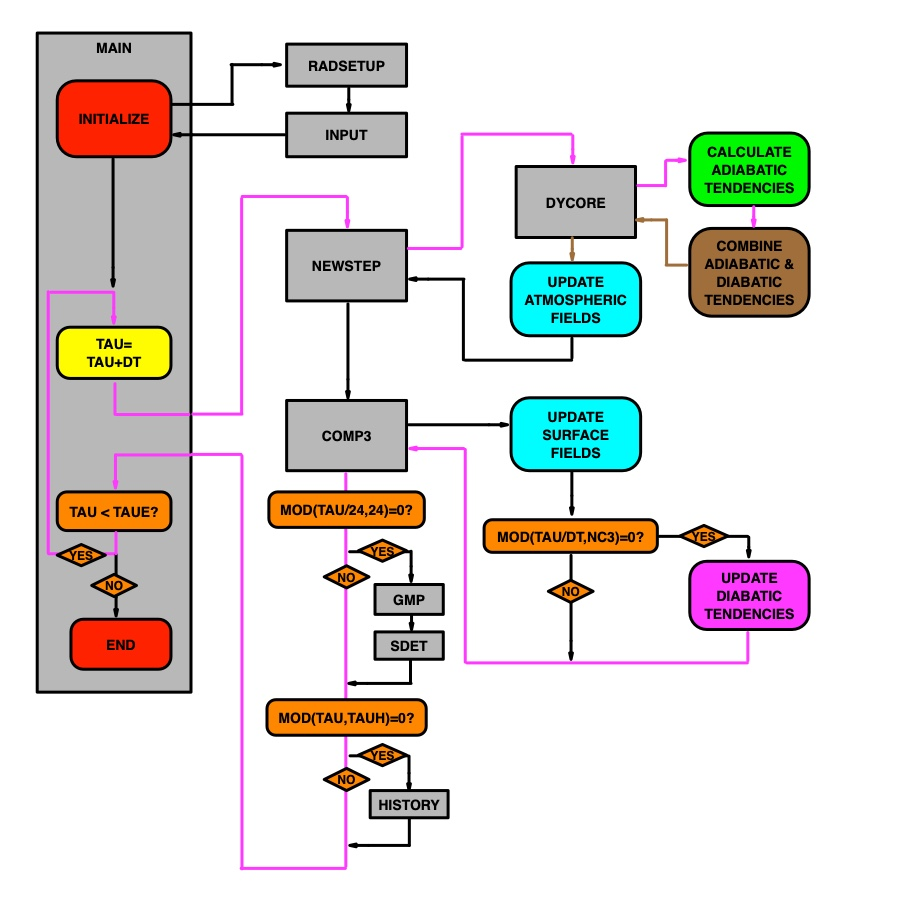

### Physics Code Architecture

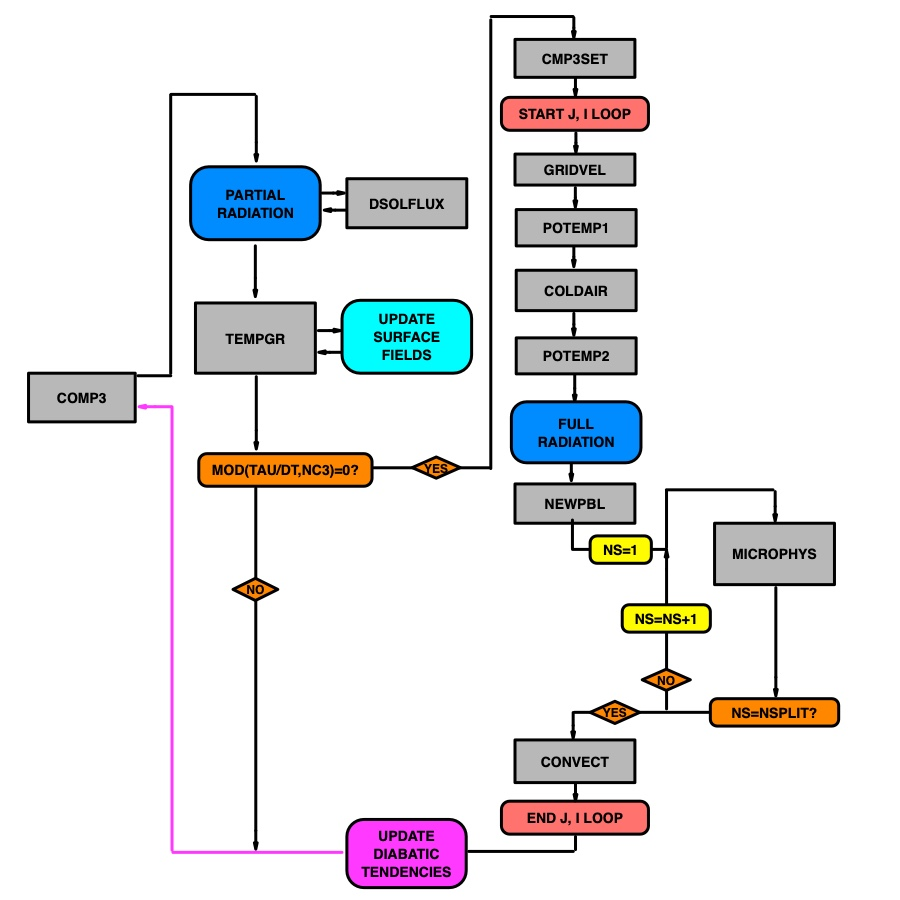


---

### This concludes the GCM Overview.  Next we will cover more practical aspects of running the GCM!